In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# torch.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset Preprocessing

Split data into train, validation and test:  
80% train, 10% validation, 10% test:

Years selected for test and validation (based of random number generation):
Valid and test years pairs are selected within one year of seperation
valid = 2022, 1999, 2008, 1990
test = 2023,  1998, 2009, 1991

Validation years

In [51]:
datafolder = "./data/"
merge_df = pd.DataFrame()
for i, file in enumerate(os.listdir(datafolder)):
    if i == 0:
        merge_df = pd.read_csv(datafolder + file)
    else:
        df = pd.read_csv(datafolder + file)
        merge_df = pd.merge(merge_df, df, on="month")

In [52]:
merge_df

,month,maximum_rainfall_in_a_day,no_of_rainy_days,total_rainfall,rh_extremes_minimum,mean_rh,mean_sunshine_hrs,mean_temp,temp_mean_daily_max,temp_mean_daily_min
0,1982-01,36.5,10,107.1,49,81.2,5.6,25.9,29.8,23.3
1,1982-02,9.4,5,27.8,49,79.5,7.6,27.1,32.3,23.9
2,1982-03,61.7,11,160.8,51,82.3,5.1,27.2,31.7,24.3
3,1982-04,45.1,14,157.0,54,85.9,4.7,27.0,31.4,24.3
4,1982-05,33.0,10,102.2,57,83.2,5.8,28.0,31.7,25.2
...,...,...,...,...,...,...,...,...,...,...
513,2024-10,66.0,15,147.6,41,78.9,5.0,28.5,32.1,25.8
514,2024-11,71.2,24,407.4,53,84.5,4.3,27.4,31.6,25.0
515,2024-12,76.8,23,234.4,41,80.7,4.6,27.7,31.7,25.3
516,2025-01,157.0,18,480.2,54,83.4,3.6,26.5,29.5,24.6


In [53]:
def normalised(df, min_max=True):
    excluded_columns = ["month"]
    merge_df_normalized_gaussian = df.copy()
    merge_df_normalized_minmax = df.copy()

    epsilon = 1e-10

    for column in merge_df_normalized_gaussian.columns:
        if column not in excluded_columns:
            merge_df_normalized_gaussian[column] = (merge_df_normalized_gaussian[column] - merge_df_normalized_gaussian[column].mean()) / merge_df_normalized_gaussian[column].std()

    for column in merge_df_normalized_minmax.columns:
        if column not in excluded_columns:
            merge_df_normalized_minmax[column] = (merge_df_normalized_minmax[column] - merge_df_normalized_minmax[column].min() + epsilon) / (merge_df_normalized_minmax[column].max() - merge_df_normalized_minmax[column].min() + epsilon)
    return merge_df_normalized_minmax if min_max else merge_df_normalized_gaussian

merge_df_normalized = normalised(merge_df, min_max=True)
merge_df_normalized

,month,maximum_rainfall_in_a_day,no_of_rainy_days,total_rainfall,rh_extremes_minimum,mean_rh,mean_sunshine_hrs,mean_temp,temp_mean_daily_max,temp_mean_daily_min
0,1982-01,0.168056,0.346154,0.139611,0.571429,0.491979,0.439394,0.121951,0.178571,0.095238
1,1982-02,0.042593,0.153846,0.036045,0.571429,0.401070,0.742424,0.414634,0.625000,0.238095
2,1982-03,0.284722,0.384615,0.209743,0.642857,0.550802,0.363636,0.439024,0.517857,0.333333
3,1982-04,0.207870,0.500000,0.204780,0.750000,0.743316,0.303030,0.390244,0.464286,0.333333
4,1982-05,0.151852,0.346154,0.133211,0.857143,0.598930,0.469697,0.634146,0.517857,0.547619
...,...,...,...,...,...,...,...,...,...,...
513,2024-10,0.304630,0.538462,0.192504,0.285714,0.368984,0.348485,0.756098,0.589286,0.690476
514,2024-11,0.328704,0.884615,0.531801,0.714286,0.668449,0.242424,0.487805,0.500000,0.500000
515,2024-12,0.354630,0.846154,0.305864,0.285714,0.465241,0.287879,0.560976,0.517857,0.571429
516,2025-01,0.725926,0.653846,0.626877,0.750000,0.609626,0.136364,0.268293,0.125000,0.404762


In [54]:
merge_df_normalized['month'] = pd.to_datetime(merge_df_normalized['month'], format='%Y-%m').dt.to_period('M')
merge_df_normalized.set_index('month', inplace=True)

merge_df_normalized

,maximum_rainfall_in_a_day,no_of_rainy_days,total_rainfall,rh_extremes_minimum,mean_rh,mean_sunshine_hrs,mean_temp,temp_mean_daily_max,temp_mean_daily_min
month,,,,,,,,,
1982-01,0.168056,0.346154,0.139611,0.571429,0.491979,0.439394,0.121951,0.178571,0.095238
1982-02,0.042593,0.153846,0.036045,0.571429,0.401070,0.742424,0.414634,0.625000,0.238095
1982-03,0.284722,0.384615,0.209743,0.642857,0.550802,0.363636,0.439024,0.517857,0.333333
1982-04,0.207870,0.500000,0.204780,0.750000,0.743316,0.303030,0.390244,0.464286,0.333333
1982-05,0.151852,0.346154,0.133211,0.857143,0.598930,0.469697,0.634146,0.517857,0.547619
...,...,...,...,...,...,...,...,...,...
2024-10,0.304630,0.538462,0.192504,0.285714,0.368984,0.348485,0.756098,0.589286,0.690476
2024-11,0.328704,0.884615,0.531801,0.714286,0.668449,0.242424,0.487805,0.500000,0.500000
2024-12,0.354630,0.846154,0.305864,0.285714,0.465241,0.287879,0.560976,0.517857,0.571429


In [55]:
X = merge_df_normalized.drop(columns=['total_rainfall']).values
y = merge_df_normalized['total_rainfall'].values


In [56]:
SEQ_LENGTH = 12

# Function to create sequences
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X, y, SEQ_LENGTH)

In [57]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [58]:
class RainfallDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(RainfallDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(RainfallDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

In [59]:

class LSTMRainfallModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2):
        super(LSTMRainfallModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for regression

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take last timestep output
        return out.squeeze()

# Initialize model
input_size = X_train.shape[2]  # Number of features
model = LSTMRainfallModel(input_size).to(device)

In [60]:
# Define loss function and optimizer
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss / len(train_loader)}")


Epoch 1/50, Loss: 0.046386895271447987
Epoch 2/50, Loss: 0.024412855577583496
Epoch 3/50, Loss: 0.022626650949510243
Epoch 4/50, Loss: 0.022029534483758304
Epoch 5/50, Loss: 0.021964770276099443
Epoch 6/50, Loss: 0.022065255934229262
Epoch 7/50, Loss: 0.022463154119367782
Epoch 8/50, Loss: 0.02244357127123154
Epoch 9/50, Loss: 0.022388831425744753
Epoch 10/50, Loss: 0.0226573866003981
Epoch 11/50, Loss: 0.022378522687806532
Epoch 12/50, Loss: 0.02233761792572645
Epoch 13/50, Loss: 0.021700295333105784
Epoch 14/50, Loss: 0.021213030585875876
Epoch 15/50, Loss: 0.020518257425954707
Epoch 16/50, Loss: 0.021020113490521908
Epoch 17/50, Loss: 0.021296228138873212
Epoch 18/50, Loss: 0.02019207229694495
Epoch 19/50, Loss: 0.020377709458653744
Epoch 20/50, Loss: 0.019873141561849758
Epoch 21/50, Loss: 0.02033826200148234
Epoch 22/50, Loss: 0.02039865332727249
Epoch 23/50, Loss: 0.01959498943044589
Epoch 24/50, Loss: 0.01985139800952031
Epoch 25/50, Loss: 0.019921331952970762
Epoch 26/50, Loss:

In [61]:
model.eval()
y_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)  # Move to GPU/CPU
        y_preds.append(model(X_batch))

y_preds = torch.cat(y_preds).cpu().numpy()

In [62]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test.cpu().numpy(), y_preds)
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.1375


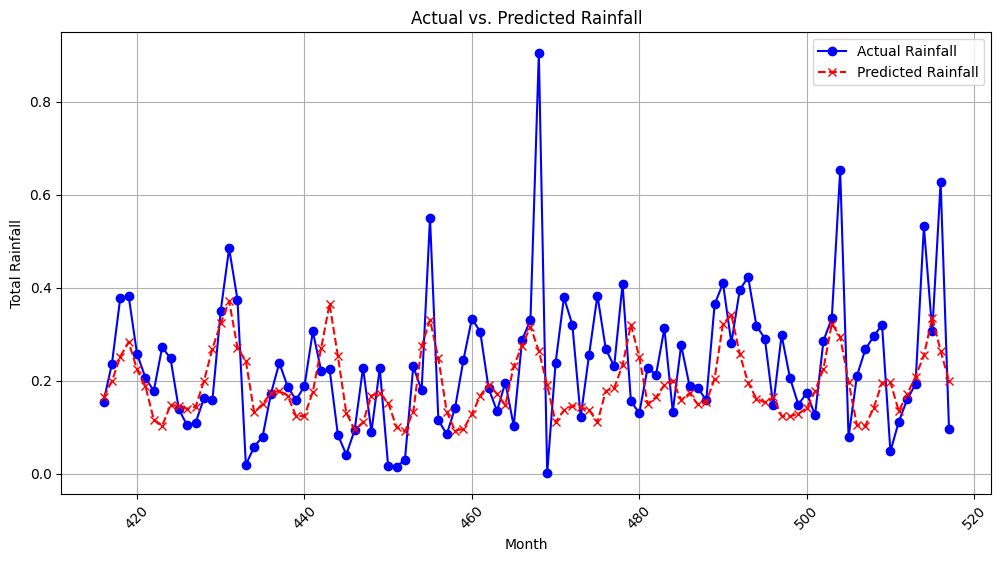

In [63]:
import matplotlib.pyplot as plt

# Move actual values to CPU if necessary
y_test_np = y_test.cpu().numpy() if y_test.is_cuda else y_test.numpy()

# Create time index (optional: if your dataset has a datetime index)
time_index = df.index[-len(y_test_np):] 

plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test_np, label="Actual Rainfall", color='blue', marker='o')
plt.plot(time_index, y_preds, label="Predicted Rainfall", color='red', linestyle='dashed', marker='x')

plt.xlabel("Month")
plt.ylabel("Total Rainfall")
plt.title("Actual vs. Predicted Rainfall")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True)
plt.show()

In [40]:
torch.save(model.state_dict(), "lstm_rainfall.pth")